In [65]:
# подключим нужные библиотеки, сразу зададим размер визуализаций

import pandahouse
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import pylab
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(11,8)})

In [36]:
# подключимся к базе и сформируем нужный нам запрос: вытащим данные по 2 группам за период АА-теста 

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220720'
}

q = '''
    SELECT exp_group, user_id, sum(if(action = 'view', 1, 0)) as views,
            sum(if(action = 'like', 1, 0)) as likes,
            likes/views as ctr
    from simulator_20220720.feed_actions
    where toDate(time) between '2022-06-06' and '2022-06-12' and exp_group in (2,3)
    group by exp_group, user_id
    
    '''
    
df = pandahouse.read_clickhouse(q, connection=connection)

df.head()


,exp_group,user_id,views,likes,ctr
0,3,115383,36,11,0.305556
1,3,123580,92,15,0.163043
2,2,131473,148,26,0.175676
3,2,23985,66,12,0.181818
4,2,24523,120,17,0.141667


In [37]:
# кол-во строк в группах примерно равно
df.groupby('exp_group')['ctr'].count()

exp_group
2    8480
3    8569
Name: ctr, dtype: int64

<AxesSubplot:xlabel='ctr', ylabel='Count'>

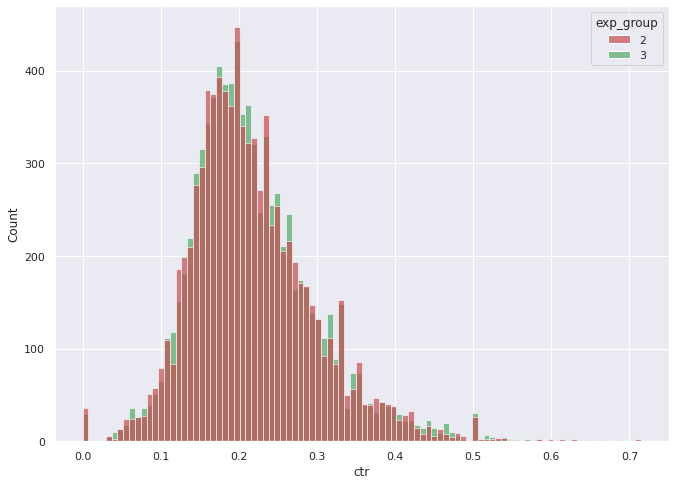

In [38]:
# распределения ctr выглядят похожими

sns.histplot(df, x = df['ctr'], hue = df['exp_group'], alpha = 0.7, palette = ['r', 'g'])

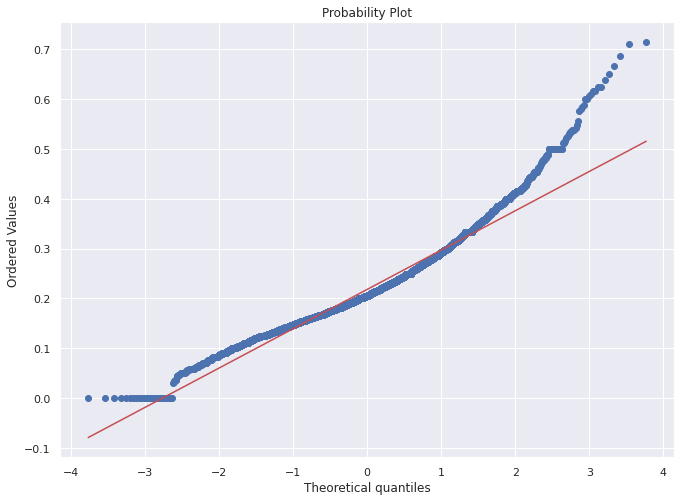

In [39]:
# Увидев подобный график, интересно проверить распределения на нормальность
stats.probplot(df[df['exp_group'] == 2]['ctr'], dist="norm", plot=pylab)
pylab.show()

ShapiroResult(statistic=0.9644902348518372, pvalue=1.2434014928786041e-09) ShapiroResult(statistic=0.9481425285339355, pvalue=3.151315796853793e-12)


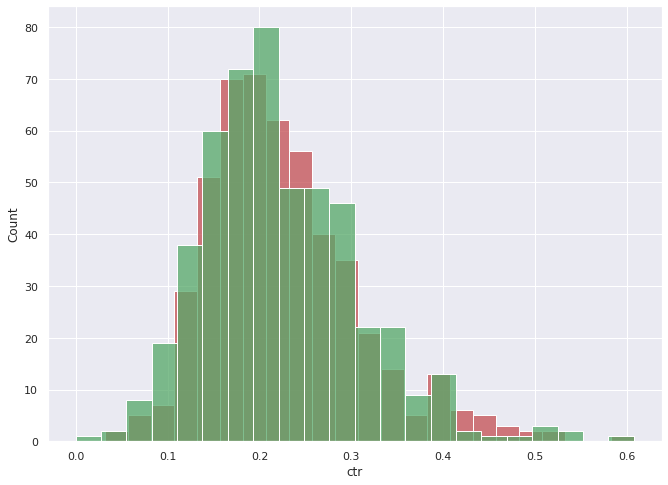

In [44]:
# распределение ненормальное. Так как в дальнейшем мы должны сравнивать случайные выборки размером 500 t-тестом (
# для которого нормальность выборок в теории является обязательной, но на практике нет), 
# то для примера возьмём две выборки однократно и проверим на номральность тестом Шапиро.

group_2 = df[df['exp_group'] == 2]['ctr'].sample(500)
group_3 = df[df['exp_group'] == 3]['ctr'].sample(500)
sns.histplot(group_3, color = 'r')
sns.histplot(group_2, color = 'g')
shapiro_2 = stats.shapiro(group_2)
shapiro_3 = stats.shapiro(group_3)
print(shapiro_2, shapiro_3)

Итак, проводим симуляцию АА-теста и проверяем Стьюдентом, несмотря на тот факт, что выборки ненормальны.

In [49]:
# симуляция АА-теста. 10000 итераций, на каждой из них берём случайные выборки (размером 500)  
# из 2 и 3 групп и сравниваем. Полученное pvalue добавляем в список.
# Критерий для проверки - критерий Стьюдента для независиымх выборок. Н0 - средние групп равны. альфа - 0.05

count_for_significant = 0
list_for_pvalues = []
for _ in range(10000):
    group_2 = df[df['exp_group'] == 2]['ctr'].sample(500)
    group_3 = df[df['exp_group'] == 3]['ctr'].sample(500)
    t = stats.ttest_ind(group_2, group_3, equal_var = False)
    if t.pvalue <= 0.05:
        count_for_significant += 1
    list_for_pvalues.append(t.pvalue)
print(len(list_for_pvalues))

10000


<AxesSubplot:ylabel='Count'>

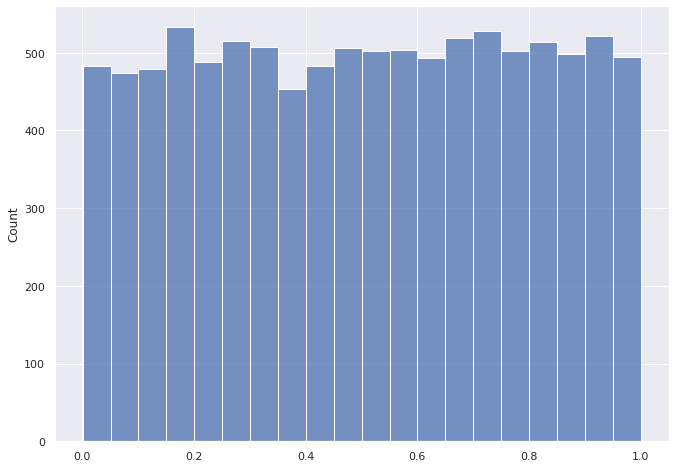

In [51]:
# построим гистограмму получившихся pvalue и увидим ожидаемое при истинности Н0 близкое к равномерному распределение

sns.histplot(list_for_pvalues, bins = 20)

In [52]:
# Уже по гистограмме легко увидеть, что процент pvalues ниже или равных 0.05 у нас меньше 5 %. Подсчитаем:
print('Процент pvalue ниже или равных 0.05:', count_for_significant*100 / len(list_for_pvalues), '%')


Процент pvalue ниже или равных 0.05: 4.77 %


Вывод:

АА-тест показывает, что сплит-система работает корректно и наши группы не имеют статистически значимых отличий друг от друга 

Text(0.5, 0, 'Общий ctr')

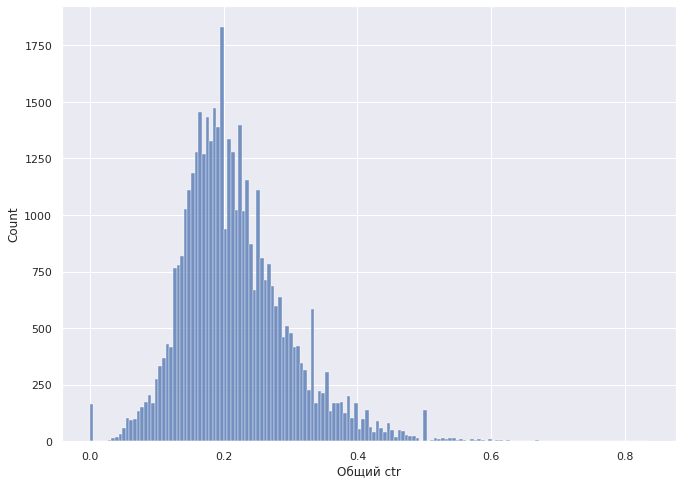

In [67]:
# проверка через дисперсионный анализ всех групп( просто из интереса, хотя, 
# как и в случае с т-тестом, требование к нормальности не выполняется )

q = '''
    SELECT exp_group, user_id, sum(if(action = 'view', 1, 0)) as views,
            sum(if(action = 'like', 1, 0)) as likes,
            likes/views as ctr
    from simulator_20220720.feed_actions
    where toDate(time) between '2022-06-06' and '2022-06-12'
    group by exp_group, user_id
    
    '''
    
df_total = pandahouse.read_clickhouse(q, connection=connection)

sns.histplot(df_total['ctr'])
plt.xlabel('Общий ctr')

In [64]:
groups = []
for i in range(5):
    groups.append(df_total[df_total['exp_group'] == i]['ctr'])

stats.f_oneway(*groups)

F_onewayResult(statistic=2.2785636066894037, pvalue=0.05832445650498165)